Going to do a simple Newtonian SWE simulation for testing 

In [264]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [265]:
nt = 100

In [266]:
# Newtonian SWE from https://en.wikipedia.org/wiki/Shallow_water_equations#Conservative_form

# set gravity and adiabatic index
g = 1.
gamma = 5./3.

# define grids
nx = 50
ny = 50
ng = 2
xmin = -10.
xmax = 10.
ymin = -10.
ymax = 10.
cfl = 0.1
rho = 1.

# coarse grid
x = np.linspace(xmin, xmax, num=nx, endpoint=False) # values of x at left boundaries
y = np.linspace(ymin, ymax, num=ny, endpoint=False) # values of y at top boundaries
q_cart = np.zeros((nt+1, nx, ny, 3))
dx = x[1] - x[0]
dy = y[1] - y[0]
dt_cart = cfl * min(dx, dy) #* 0.001
# now shift to centres
x += 0.5 * dx
y += 0.5 * dy

def flux(q, x_dir=True):
    # q = (h, hu, hv)
    # f = (hu, hu**2 + 0.5*g*h**2, huv)
    f = np.zeros_like(q)
    if x_dir:
        f[:,:,0] = q[:,:,1]
        f[:,:,1] = q[:,:,1]**2 / q[:,:,0] + 0.5 * g * q[:,:,0]**2
        f[:,:,2] = q[:,:,1]*q[:,:,2] / q[:,:,0]
    else:
        f[:,:,0] = q[:,:,2]
        f[:,:,1] = q[:,:,1]*q[:,:,2] / q[:,:,0]
        f[:,:,2] = q[:,:,2]**2 / q[:,:,0] + 0.5 * g * q[:,:,0]**2
    return f

def bcs(grid):
    # outflow boundary conditions 
    grid[:ng,:,:] = grid[ng,:,:]
    grid[-ng:,:,:] = grid[-ng-1,:,:]
    
    grid[:,:ng,:] = grid[:,ng,np.newaxis,:]
    grid[:,-ng:,:] = grid[:,-ng-1,np.newaxis,:]

def evolve(q, dx, dy, d_t):

    qx_p = np.zeros_like(q[1:-1,1:-1,:])
    qx_m = np.zeros_like(q[1:-1,1:-1,:])
    
    fx_p = np.zeros_like(q[1:-1,1:-1,:])
    fx_m = np.zeros_like(q[1:-1,1:-1,:])
    
    qy_p = np.zeros_like(q[1:-1,1:-1,:])
    qy_m = np.zeros_like(q[1:-1,1:-1,:])
    
    fy_p = np.zeros_like(q[1:-1,1:-1,:])
    fy_m = np.zeros_like(q[1:-1,1:-1,:])
    
    # x-direction
    S_upwind = (q[2:,1:-1,:] - q[1:-1,1:-1,:]) / dx
    S_downwind = (q[1:-1,1:-1,:] - q[:-2,1:-1,:]) / dx
    S = 0.5 * (S_upwind + S_downwind)
    r = np.ones_like(S) * 1.e6
    r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
    ph = np.zeros_like(r)
    for i in range(len(ph[:,0])):
        ph[i,:] = phi(r[i,:])
    S *= ph
    
    qx_p = q[1:-1,1:-1,:] + S * 0.5 * dx
    qx_m = q[1:-1,1:-1,:] - S * 0.5 * dx
    
    # y-direction
    S_upwind = (q[1:-1,2:,:] - q[1:-1,1:-1,:]) / dy
    S_downwind = (q[1:-1,1:-1,:] - q[1:-1,:-2,:]) / dy
    S = 0.5 * (S_upwind + S_downwind)
    r = np.ones_like(S) * 1.e6
    r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
    ph = np.zeros_like(r)
    for i in range(len(ph[:,0])):
        ph[i,:] = phi(r[i,:])
    S *= ph
    
    qy_p = q[1:-1,1:-1,:] + S * 0.5 * dy
    qy_m = q[1:-1,1:-1,:] - S * 0.5 * dy
        
    # calculate fluxes at boundaries
    fx_p = flux(qx_p)   
    fx_m = flux(qx_m)
    fy_p = flux(qy_p, x_dir=False)   
    fy_m = flux(qy_m, x_dir=False)
    
    alpha = 1.#cfl * min(dx, dy) / d_t
    
    # Lax-Friedrichs flux
    Fx_m = 0.5 * (fx_p[:-2,1:-1,:] + fx_m[1:-1,1:-1,:] + alpha * (qx_p[:-2,1:-1,:] - qx_m[1:-1,1:-1,:]))
    Fx_p = 0.5 * (fx_p[1:-1,1:-1,:] + fx_m[2:,1:-1,:] + alpha * (qx_p[1:-1,1:-1,:] - qx_m[2:,1:-1,:]))
    Fy_m = 0.5 * (fy_p[1:-1,:-2,:] + fy_m[1:-1,1:-1,:] + alpha * (qy_p[1:-1,:-2,:] - qy_m[1:-1,1:-1,:]))
    Fy_p = 0.5 * (fy_p[1:-1,1:-1,:] + fy_m[1:-1,2:,:] + alpha * (qy_p[1:-1,1:-1,:] - qy_m[1:-1,2:,:]))
    
    F = np.zeros_like(q)
    
    F[2:-2,2:-2,:] = -alpha * ((Fx_p - Fx_m) / dx + (Fy_p - Fy_m) / dy)
    
    #if flux_func == shallow_water_fluxes:
    bcs(F)
    
    return F

def rk3(q, d_t, d_x, d_y):
    # third order runge-kutta
    F = evolve(q, d_x, d_y, d_t)
    
    q_temp = q + d_t * F
    
    F = evolve(q_temp, d_x, d_y, d_t)
    
    q_temp = 0.25 * (3. * q + q_temp + d_t * F)
    
    F = evolve(q_temp, d_x, d_y, d_t)
    
    return (q + 2. * q_temp + 2. * d_t * F) / 3.

def phi(r):
    # MC limiter 
    return np.maximum(0.0, np.minimum(1,2.*r), np.minimum(2., r))

In [267]:
rr = np.sqrt((x[:,np.newaxis])**2 + (y[np.newaxis,:])**2)
q_cart[0,:,:,0] = 1. + 0.1 * np.exp(-(rr-5.)**2*2) #0.01 * np.sin(0.25 * np.pi + 2. * np.pi * x / (xmax - xmin)) + 1.
bcs(q_cart[0,:,:,:])

for t in range(nt):
    q_cart[t+1,:,:,:] = rk3(q_cart[t,:,:,:], dt_cart, dx, dy)

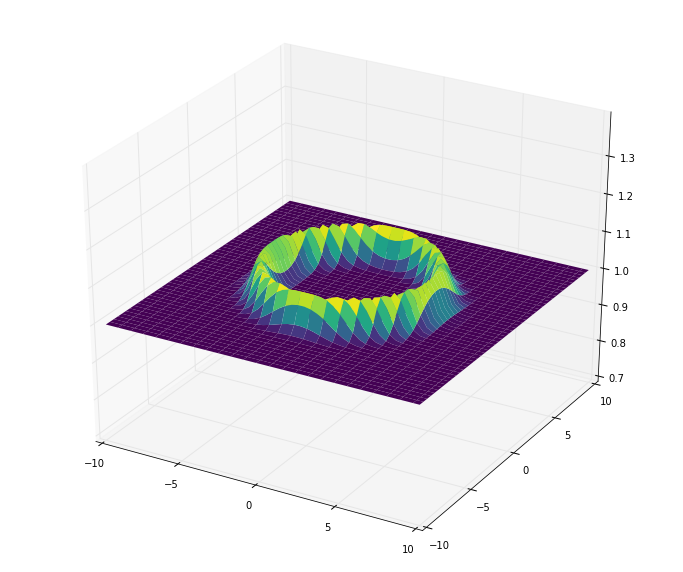

In [268]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')

X,Y = np.meshgrid(x, y)

surface_1 = ax.plot_surface(X,Y,q_cart[0,:,:,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

def animate(i):
    ax.clear()
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    ax.set_zlim(0.7,1.4)
    ax.plot_surface(X,Y,q_cart[i,:,:,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

anim = animation.FuncAnimation(fig, animate, frames=int(nt), interval=40)

In [269]:
HTML(anim.to_html5_video())

# Polar coordinates

Now going to try and do the above but in polar coordinates

In [299]:
# set gravity and adiabatic index
g = 1.
gamma = 5./3.

# define grids
nr = 30
nph = 20
ng = 2
rmin = 3.
rmax = 10.
phmin = 0.
phmax = 2. * np.pi
cfl = 0.1
rho = 1.

# coarse grid
r = np.linspace(rmin, rmax, num=nr, endpoint=False) # values of r at inner boundaries
ph = np.linspace(phmin, phmax, num=nph, endpoint=True) # values of ph at top boundaries
q_cyl = np.zeros((nt+1, nr, nph, 3))
dr = r[1] - r[0]
dph = ph[1] - ph[0]
dt = dt_cart#cfl * min(dt_cart, min(dr, np.amin(r * dph)))
# now shift to centres
r += 0.5 * dr
ph += 0.5 * dph

def cyl_flux(q, r_dir=True):
    # q = (h, hu, hv)
    # f = (hu, hu**2 + 0.5*g*h**2, huv)
    f = np.zeros_like(q)
    if r_dir:
        f[:,:,0] = q[:,:,1]
        f[:,:,1] = q[:,:,1]**2 / q[:,:,0] + 0.5 * g * q[:,:,0]**2
        f[:,:,2] = q[:,:,1]*q[:,:,2] / q[:,:,0]
    else:
        f[:,:,0] = q[:,:,2]
        f[:,:,1] = q[:,:,1]*q[:,:,2] / q[:,:,0]
        f[:,:,2] = q[:,:,2]**2 / q[:,:,0] + 0.5 * g * q[:,:,0]**2
    return f

def cyl_bcs(grid):
    # outflow boundary conditions for r direction
    #grid[:ng,:,:] = grid[ng,:,:]
    #grid[-ng:,:,:] = grid[-ng-1,:,:]
    
    # periodic boundary conditions for phi direction
    grid[:,:ng,:] = grid[:,-2*ng:-ng,:]
    grid[:,-ng:,:] = grid[:,ng:2*ng,:]

def cyl_evolve(q, d_r, d_ph, d_t):

    qr_p = np.zeros_like(q[1:-1,1:-1,:])
    qr_m = np.zeros_like(q[1:-1,1:-1,:])
    
    fr_p = np.zeros_like(q[1:-1,1:-1,:])
    fr_m = np.zeros_like(q[1:-1,1:-1,:])
    
    qph_p = np.zeros_like(q[1:-1,1:-1,:])
    qph_m = np.zeros_like(q[1:-1,1:-1,:])
    
    fph_p = np.zeros_like(q[1:-1,1:-1,:])
    fph_m = np.zeros_like(q[1:-1,1:-1,:])
    
    # r-direction
    S_upwind = (q[2:,1:-1,:] - q[1:-1,1:-1,:]) 
    S_downwind = (q[1:-1,1:-1,:] - q[:-2,1:-1,:]) 
    S = 0.5 * (S_upwind + S_downwind)
    ratio = np.ones_like(S) * 1.e6
    ratio[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
    _ph = np.zeros_like(ratio)
    for i in range(len(_ph[:,0])):
        _ph[i,:] = phi(ratio[i,:])
    S *= _ph
    
    qr_p = q[1:-1,1:-1,:] + S * 0.5 
    qr_m = q[1:-1,1:-1,:] - S * 0.5 
    
    # y-direction
    S_upwind = (q[1:-1,2:,:] - q[1:-1,1:-1,:]) 
    S_downwind = (q[1:-1,1:-1,:] - q[1:-1,:-2,:]) 
    S = 0.5 * (S_upwind + S_downwind)
    ratio = np.ones_like(S) * 1.e6
    ratio[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
    _ph = np.zeros_like(ratio)
    for i in range(len(_ph[:,0])):
        _ph[i,:] = phi(ratio[i,:])
    S *= _ph
    
    qph_p = q[1:-1,1:-1,:] + S * 0.5 
    qph_m = q[1:-1,1:-1,:] - S * 0.5 
        
    # calculate fluxes at boundaries
    fr_p = cyl_flux(qr_p)   
    fr_m = cyl_flux(qr_m)
    fph_p = cyl_flux(qph_p, r_dir=False)   
    fph_m = cyl_flux(qph_m, r_dir=False)
    
    alpha = 1.#cfl * min(dr, rmin*dph) / dt
    
    # Lax-Friedrichs flux
    Fr_m = 0.5 * (fr_p[:-2,1:-1,:] + fr_m[1:-1,1:-1,:] + alpha * (qr_p[:-2,1:-1,:] - qr_m[1:-1,1:-1,:]))
    Fr_p = 0.5 * (fr_p[1:-1,1:-1,:] + fr_m[2:,1:-1,:] + alpha * (qr_p[1:-1,1:-1,:] - qr_m[2:,1:-1,:]))
    Fph_m = 0.5 * (fph_p[1:-1,:-2,:] + fph_m[1:-1,1:-1,:] + alpha * (qph_p[1:-1,:-2,:] - qph_m[1:-1,1:-1,:]))
    Fph_p = 0.5 * (fph_p[1:-1,1:-1,:] + fph_m[1:-1,2:,:] + alpha * (qph_p[1:-1,1:-1,:] - qph_m[1:-1,2:,:]))
    
    F = np.zeros_like(q)
    
    F[2:-2,2:-2,:] = -alpha / (r[2:-2, np.newaxis, np.newaxis] * d_r * d_ph) * \
        ((Fr_p - Fr_m) * (r[2:-2, np.newaxis, np.newaxis] * d_ph) + (Fph_p - Fph_m) * d_r)
    
    #if flux_func == shallow_water_fluxes:
    cyl_bcs(F)
    
    return F

def cyl_rk3(q, d_t, d_r, d_ph):
    # third order runge-kutta
    F = cyl_evolve(q, d_r, d_ph, d_t)
    
    q_temp = q + d_t * F
    
    F = cyl_evolve(q_temp, d_r, d_ph, d_t)
    
    q_temp = 0.25 * (3. * q + q_temp + d_t * F)
    
    F = cyl_evolve(q_temp, d_r, d_ph, d_t)
    
    return (q + 2. * q_temp + 2. * d_t * F) / 3.

def phi(ratio):
    # MC limiter 
    return np.maximum(0.0, np.minimum(1,2.*ratio), np.minimum(2., ratio))

In [300]:
q_cyl[0,:,:,0] = 1. + 0.1 * np.exp(-(r[:,np.newaxis]-5)**2*2) #0.01 * np.sin(0.25 * np.pi + 2. * np.pi * x / (xmax - xmin)) + 1.
cyl_bcs(q_cyl[0,:,:,:])
for t in range(nt):
    q_cyl[t+1,:,:,:] = cyl_rk3(q_cyl[t,:,:,:], dt_cart, dr, dph)

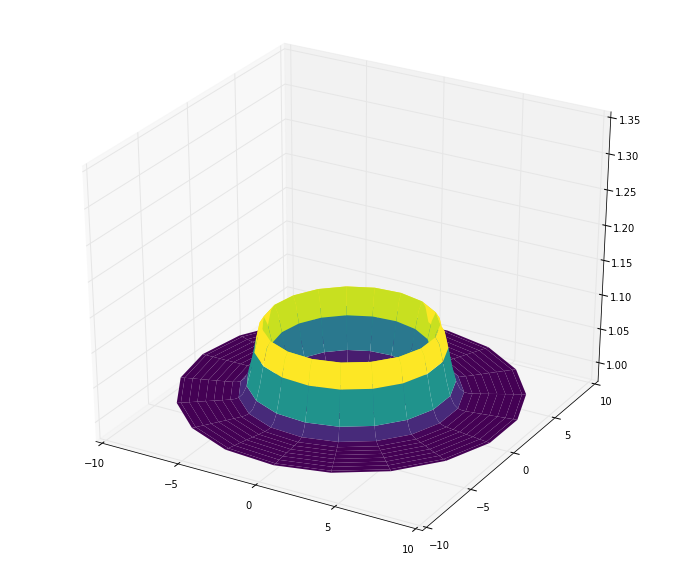

In [301]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')

R, P = np.meshgrid(r, ph)
X, Y = R*np.cos(P), R*np.sin(P)

surface_1 = ax.plot_surface(X,Y,q_cyl[0,:,:,0].T, rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

def animate(i):
    ax.clear()
    #ax.set_xlim(0,10)
    #ax.set_ylim(0,10)
    ax.set_zlim(0.98,1.35)
    ax.plot_surface(X,Y,q_cyl[i,:,:,0].T, rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

anim = animation.FuncAnimation(fig, animate, frames=int(nt), interval=40)

In [302]:
HTML(anim.to_html5_video())

# Patches

In [313]:
ng = 3
nt = 100

# first need to determine locations of ghost cells' centres 
R, P = np.meshgrid(r, ph)
X, Y = R.T*np.cos(P.T), R.T*np.sin(P.T)

def update_ghosts(qa, qb):

    # cartesian grid needs to interpolate data to these points 
    def interpolate(q_b, xa, ya, xs_b, ys_b):
        # q_b = data on grid b
        # x, y = coords want to interpolate to 
        # xs_b, ys_b = coords on b 

        # indices of x, y in grid b that are to the right of target xa, ya
        x_i = 0
        y_i = 0

        d_x = xs_b[1] - xs_b[0]
        d_y = ys_b[1] - ys_b[0] # assume this is constant

        while xs_b[x_i] < xa:
            x_i += 1
        while ys_b[y_i] < ya:
            y_i += 1

        x_frac = (xa - xs_b[x_i-1]) / d_x
        y_frac = (ya - ys_b[y_i-1]) / d_y

        # first interpolate in x-direction 
        q1 = q_b[x_i-1,y_i-1,:] * (1. - x_frac) + q_b[x_i,y_i-1,:] * x_frac
        q2 = q_b[x_i-1,y_i,:] * (1. - x_frac) + q_b[x_i,y_i,:] * x_frac

        # then interpolate in y-direction 
        return q1 * (1. - y_frac) + q2 * y_frac

    q_ghost = qa[:ng, :, :]

    for i in range(ng):
        for j in range(nph):
            q_ghost[i, j, :] = interpolate(qb, X[i,j], Y[i,j], x, y)

    # once have interpolated, need to transform coordinate system (ie change velocities from ux, uy to ur, uphi)
    def transform(ux, uy, phs, rs):
        ur = ux * np.cos(phs[np.newaxis,:]) + uy * np.sin(phs[np.newaxis,:])
        uph = (-ux * np.sin(phs[np.newaxis,:]) + uy * np.cos(phs[np.newaxis,:])) / rs[:, np.newaxis]

        return ur, uph

    urs, uphs = transform(q_ghost[:,:,1], q_ghost[:,:,2], ph, r[:ng])

    # copy back to grid
    qa[:ng, :, 0] = q_ghost[:,:,0]
    qa[:ng, :, 1] = urs
    qa[:ng, :, 2] = uphs

In [314]:
def evolve_patches(t, d_t):
    q_cart[t+1,:,:,:] = rk3(q_cart[t,:,:,:], d_t, dx, dy)
    q_cyl[t+1,:,:,:] = cyl_rk3(q_cyl[t,:,:,:], d_t, dr, dph)
    update_ghosts(q_cyl[t+1,:,:,:], q_cart[t+1,:,:,:])

q_cart = np.zeros((nt+1, nx, ny, 3))
rr = np.sqrt((x[:,np.newaxis])**2 + (y[np.newaxis,:])**2)
q_cart[0,:,:,0] = 1. + 0.1 * np.exp(-(rr-5.)**2*2) #0.01 * np.sin(0.25 * np.pi + 2. * np.pi * x / (xmax - xmin)) + 1.
bcs(q_cart[0,:,:,:])
q_cyl = np.zeros((nt+1, nr, nph, 3))
q_cyl[0,:,:,0] = 1. + 0.1 * np.exp(-(r[:,np.newaxis]-5)**2*2) #0.01 * np.sin(0.25 * np.pi + 2. * np.pi * x / (xmax - xmin)) + 1.
cyl_bcs(q_cyl[0,:,:,:])

for t in range(nt):
    evolve_patches(t, dt)

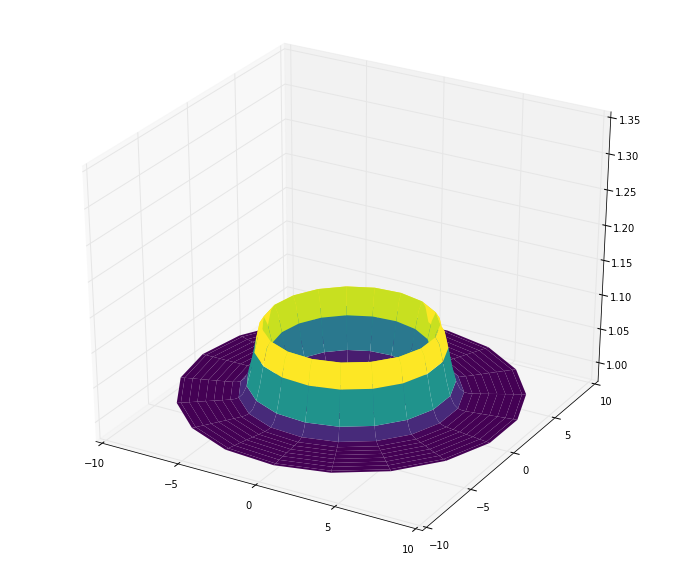

In [315]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')

R, P = np.meshgrid(r, ph)
X, Y = R*np.cos(P), R*np.sin(P)

surface_1 = ax.plot_surface(X,Y,q_cyl[0,:,:,0].T, rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

def animate(i):
    ax.clear()
    #ax.set_xlim(0,10)
    #ax.set_ylim(0,10)
    ax.set_zlim(0.98,1.35)
    ax.plot_surface(X,Y,q_cyl[i,:,:,0].T, rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

anim = animation.FuncAnimation(fig, animate, frames=int(nt), interval=40)

In [316]:
HTML(anim.to_html5_video())

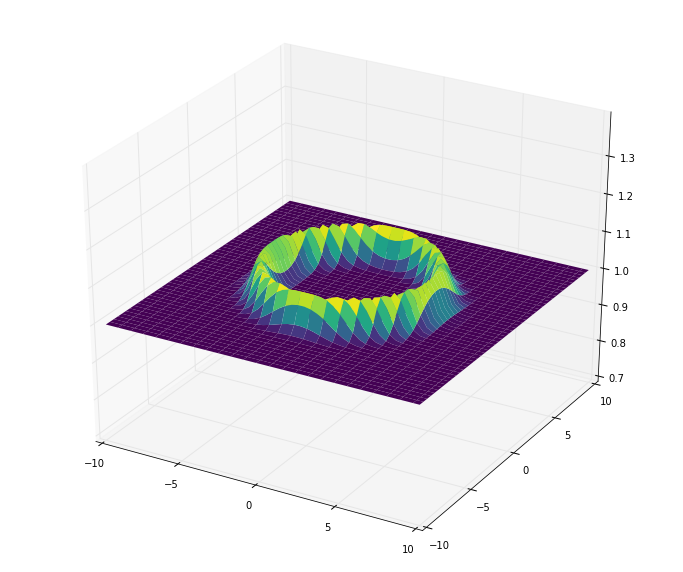

In [307]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')

X,Y = np.meshgrid(x, y)

surface_1 = ax.plot_surface(X,Y,q_cart[0,:,:,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

def animate(i):
    ax.clear()
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    ax.set_zlim(0.7,1.4)
    ax.plot_surface(X,Y,q_cart[i,:,:,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

anim = animation.FuncAnimation(fig, animate, frames=int(nt), interval=40)

In [308]:
HTML(anim.to_html5_video())

In [311]:
P[:,0]

array([ 0.16534698,  0.49604095,  0.82673491,  1.15742887,  1.48812284,
        1.8188168 ,  2.14951076,  2.48020473,  2.81089869,  3.14159265,
        3.47228662,  3.80298058,  4.13367454,  4.46436851,  4.79506247,
        5.12575643,  5.4564504 ,  5.78714436,  6.11783833,  6.44853229])